In [16]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from PIL import Image

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# VGG Imports
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras import layers, models

import cv2


In [17]:
# Data locations
base_dir = '/Users/sumitkamra/code/rajarajeswarir/melanoma_classification/melanoma_cancer_dataset'
train_dir = os.path.join(base_dir, 'train')
train_dir_list = os.listdir(train_dir)
train_dir_list

['malignant', 'benign']

In [18]:
# Number of images for each disease
num_train = {}
num_val = {}
for dir in train_dir_list:
    num_train[dir] = len(os.listdir(train_dir + '/' + dir))
img_per_class_train = pd.DataFrame(num_train.values(), index=num_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
malignant,4605
benign,5000


<Axes: title={'center': 'Training Data Distribution '}, xlabel='Categories', ylabel='Number of images'>

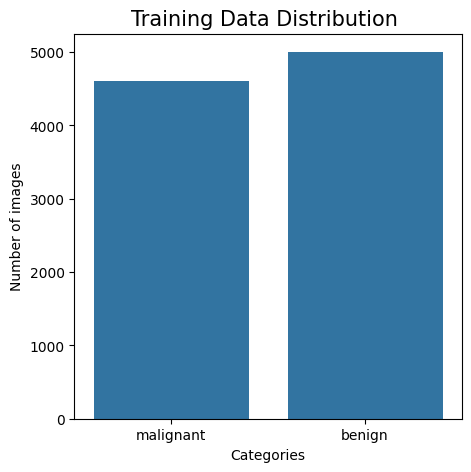

In [19]:
plt.figure(figsize=(5,5))
plt.title('Training Data Distribution ',fontsize=15)
plt.ylabel('Number of images',fontsize=10)
plt.xlabel('Categories',fontsize=10)

keys = list(num_train.keys())
vals = list(num_train.values())
sns.barplot(x=keys, y=vals)

In [20]:
# Loading data

def load_data(data_path, data_size = 500):
      classes = {'benign':0, 'malignant':1}
      imgs = []
      labels = []
      for (cl, i) in classes.items():
          images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
          for img in tqdm(images_path):
              path = os.path.join(data_path, cl, img)
              if os.path.exists(path):
                  image = Image.open(path)
                  image = image.resize((256, 256))
                  imgs.append(np.array(image))
                  labels.append(i)

      X = np.array(imgs)
      num_classes = len(set(labels))
      y = to_categorical(labels, num_classes)

      # Finally we shuffle:
      p = np.random.permutation(len(X))
      X, y = X[p], y[p]
      return X[:data_size], y[:data_size]

In [21]:
X, y = load_data(train_dir)

100%|██████████| 4605/4605 [00:07<00:00, 644.85it/s]


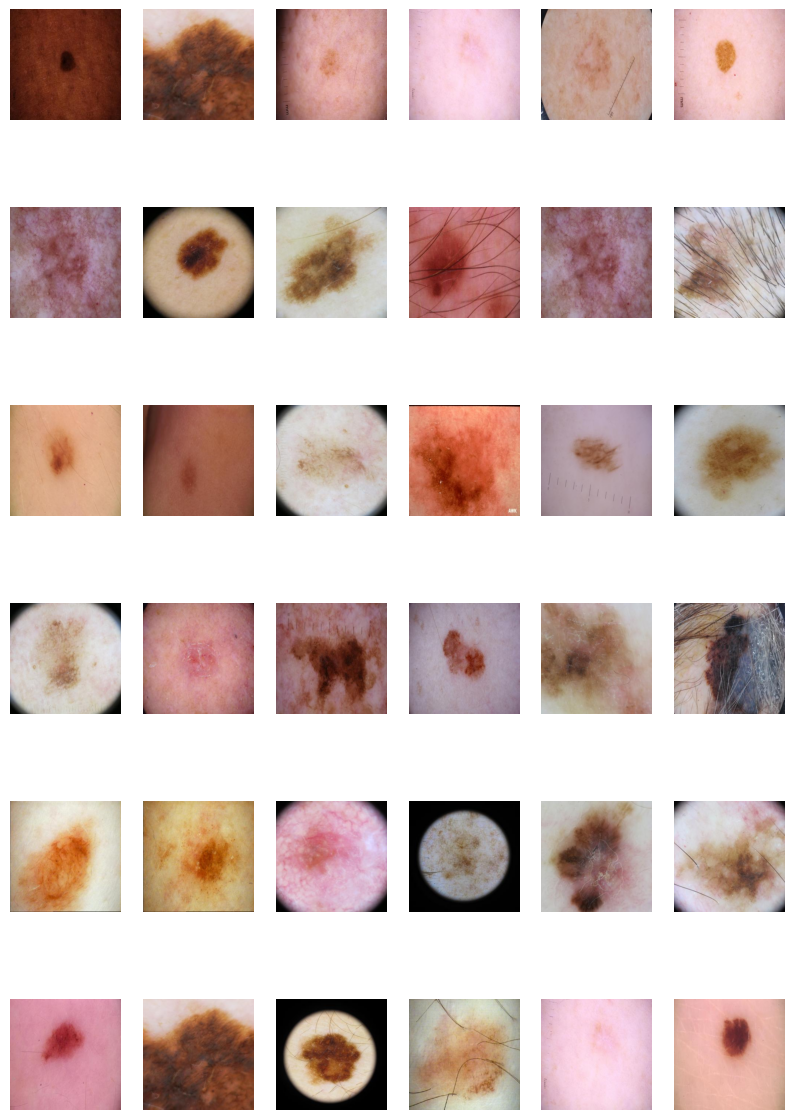

In [22]:
plt.figure(figsize=(10,15))
for n , i in enumerate(list(np.random.randint(0,len(X),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X[i])
    plt.axis('off')


In [23]:
# Use transfer learning to fit the model


def load_pre_trained_model(train_weights=False, input_shape=(224, 224, 3)):

    ## Loading VGG16 model
    model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    model.trainable = train_weights ## Not trainable weights

    ## Preprocessing input
    #X_train = preprocess_input(X_train)
    #X_test = preprocess_input(X_test)

    return model

In [24]:
base_model = load_pre_trained_model()
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
# Add layers to the model

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


vgg_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [26]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 50)                1254450   
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 2)                 42        
                                                                 
Total params: 15970200 (60.92 MB)
Trainable params: 1255512 (4.79 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [27]:
# Preprocessing the data

def resize(X, dim = (224, 224)):
    X = np.array([cv2.resize(img, dim) for img in X])
    return X

def normalize(X):
    X = X / 255.0
    return X

def preprocess(X):
    X = resize(X)
    X = normalize(X)
    return X

In [28]:
# Model training

from tensorflow.keras.callbacks import EarlyStopping

def compile_model(model, metrics=['accuracy']):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics
    )
    return model

def model_train(model, X, y, epochs=50, batch_size=32, callbacks=None):
    history = model.fit(X, y, epochs=epochs, validation_split = 0.3,
                        batch_size=batch_size,
                        callbacks=callbacks)
    return history

vgg_model = compile_model(vgg_model)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
history = model_train(vgg_model, preprocess(X), y, epochs=50, batch_size=32, callbacks=[es])

Epoch 1/50
11/11 [==============================] - 37s 3s/step - loss: 0.6212 - accuracy: 0.6314 - val_loss: 0.4622 - val_accuracy: 0.7600
Epoch 2/50
11/11 [==============================] - 37s 4s/step - loss: 0.3733 - accuracy: 0.8457 - val_loss: 0.3332 - val_accuracy: 0.8533
Epoch 3/50
11/11 [==============================] - 37s 3s/step - loss: 0.3400 - accuracy: 0.8686 - val_loss: 0.3668 - val_accuracy: 0.8333
Epoch 4/50
11/11 [==============================] - 37s 3s/step - loss: 0.2612 - accuracy: 0.8914 - val_loss: 0.2780 - val_accuracy: 0.9000
Epoch 5/50
11/11 [==============================] - 36s 3s/step - loss: 0.2073 - accuracy: 0.9286 - val_loss: 0.2865 - val_accuracy: 0.8800
Epoch 6/50
11/11 [==============================] - 36s 3s/step - loss: 0.1709 - accuracy: 0.9486 - val_loss: 0.2689 - val_accuracy: 0.9000
Epoch 7/50
11/11 [==============================] - 36s 3s/step - loss: 0.1484 - accuracy: 0.9543 - val_loss: 0.2774 - val_accuracy: 0.8933
Epoch 8/50
11/11 [==

In [29]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

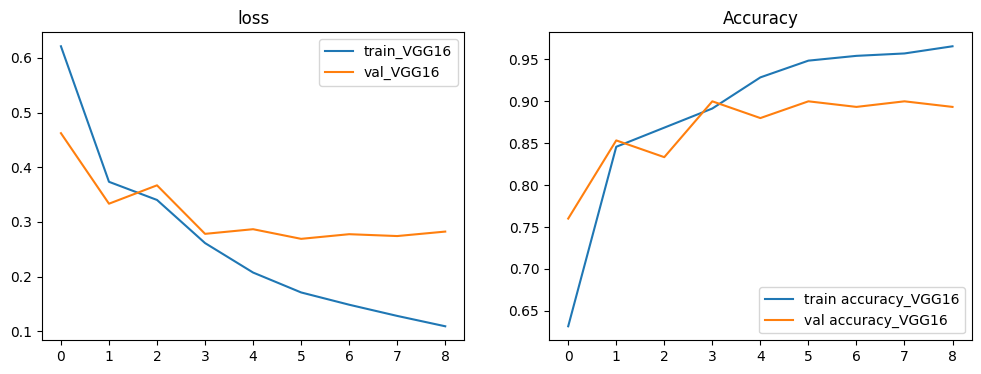

In [30]:
plot_history(history, exp_name="VGG16")

In [31]:
# Test data prediction
test_dir = os.path.join(base_dir, 'test')
X_test, y_test = load_data(test_dir, data_size=500)

loss, accuracy = vgg_model.evaluate(preprocess(X_test), y_test)

print("Test accuracy: {:.2f}%".format(accuracy * 100))


100%|██████████| 500/500 [00:00<00:00, 618.34it/s]


16/16 [==============================] - 38s 2s/step - loss: 0.3131 - accuracy: 0.8600
Test accuracy: 86.00%
